In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)

In [ ]:
!pip install transformers datasets evaluate concrete-ml

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/Team 3 Stats 170A/

/content/drive/.shortcut-targets-by-id/1krMBdL4-IHUoygOjMcfJge4gCwgJrxnz/Team 3 Stats 170A


In [7]:
df = pd.read_csv("./labeling_data/all_labels_encoded_may7.csv")
df.head()

,title,text,post_id,fortinoj@uci.edu,kangml@uci.edu,kezhang@uci.edu,suyeoj2@uci.edu,wregiste@uci.edu,Majority Vote,labels,...,FINANCIAL,FOOD,HEALTH,HOUSING,JOBS,MARKETPLACE,MISSING ITEMS,SOCIAL LIFE,TRANSPORTATION,UNCLASSIFIED
0,Looking for sublease august,Doing summer session 2 and looking for a suble...,w2f42d,Housing,Housing,Housing,Housing,Housing,HOUSING,['HOUSING'],...,0,0,0,1,0,0,0,0,0,0
1,Regarding financial aid,So I haven’t signed up for 22-23 financial aid...,tlyrdp,Financial,Financial,Financial,Financial,Financial,FINANCIAL,['FINANCIAL'],...,1,0,0,0,0,0,0,0,0,0
2,What’s the chance of getting the 1b1b floor pl...,I didn’t receive a renew in my current communi...,evvzm9,Housing,Housing,Housing,Housing,Housing,HOUSING,['HOUSING'],...,0,0,0,1,0,0,0,0,0,0
3,summer classes fin aid &amp; housing??,has anyone taken summer classes at ucr &amp; s...,ebssf5,Housing ;<br> Financial ;<br> Academic,Housing ;<br> Financial,Housing ;<br> Financial,Housing ;<br> Financial,Housing ;<br> Financial ;<br> Academic,HOUSING \n FINANCIAL \n ACADEMIC,"['FINANCIAL', 'HOUSING', 'ACADEMIC']",...,1,0,0,1,0,0,0,0,0,0
4,Can you make changes to acc floor plans?,Submitted my app days ago but am rethinking th...,s9e71v,Housing,Housing,Housing,Housing,Housing,HOUSING,['HOUSING'],...,0,0,0,1,0,0,0,0,0,0


## Get Hidden States

In [8]:
df['combined_text'] = df['title']
df['combined_text'] = df['combined_text'] + ' ' + df['text'].fillna('NaN')

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# distil-model is a distiled (smaller but similar performance) version of the original model 
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
# Load the pre-trained model
transformer_model = AutoModelForSequenceClassification.from_pretrained(
   "distilroberta-base"
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

In [10]:
import tqdm

def text_to_tensor(
    list_text_X_train: list,
    transformer_model: AutoModelForSequenceClassification,
    tokenizer: AutoTokenizer,
    device: str,
    batch_size: int = 16,
) -> np.ndarray:
    # Send the model to the device
    transformer_model = transformer_model.to(device)
    output_hidden_states_list = []

    num_batches = len(list_text_X_train) // batch_size + int(len(list_text_X_train) % batch_size != 0)

    for i in tqdm.tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        # Tokenize and pad the text in the current batch
        tokenized_text_X_batch = tokenizer(
            list_text_X_train[start_idx:end_idx],
            return_tensors="pt",
            truncation=True,
            padding='longest',
        )

        # Pass the tokens through the transformer model and get the hidden states
        # Only keep the last hidden layer state for now
        tokenized_x = tokenized_text_X_batch['input_ids'].to(device)
        attention_mask = tokenized_text_X_batch['attention_mask'].to(device)
        output_hidden_states = transformer_model(tokenized_x, attention_mask=attention_mask, output_hidden_states=True)[
            1
        ][-1]

        # Average over the tokens axis to get a representation at the text level.
        output_hidden_states = output_hidden_states.mean(dim=1)
        output_hidden_states = output_hidden_states.detach().cpu().numpy()
        output_hidden_states_list.append(output_hidden_states)

    return np.concatenate(output_hidden_states_list, axis=0)


In [11]:
all_hidden_states = text_to_tensor(list(df.combined_text), transformer_model, tokenizer, device, 32)

100%|██████████| 89/89 [00:28<00:00,  3.14it/s]


## Setup, Train, Evaluate Models

In [12]:
X = all_hidden_states
y = list(df.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [13]:
parameters = {
    "max_depth": [3, 4],
    "n_estimators": [70, 100],
    'learning_rate': [0.01, 0.1]
}
scoring = ['recall', 'precision', 'f1', 'accuracy']

In [ ]:
y_train_labels = df.loc[y_train]['ACADEMIC']
grid_search = GridSearchCV(XGBClassifier(scale_pos_weight=((len(y_train_labels) - sum(y_train_labels))/len(y_train_labels))),
                        parameters, cv=5, scoring=scoring,
                        refit='f1')
grid_search.fit(X_train, y_train_labels)

In [ ]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

In [ ]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(df.loc[y_test]['ACADEMIC'], preds))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87       478
           1       0.80      0.59      0.68       227

    accuracy                           0.82       705
   macro avg       0.81      0.76      0.77       705
weighted avg       0.82      0.82      0.81       705



In [ ]:
grid_search.best_params_
#print(grid_search.best_params_["learning_rate"])

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [ ]:
from sklearn.metrics import classification_report

In [15]:
best_models_weighted = []
for column in ['ACADEMIC', 'ADMISSIONS', 'FINANCIAL',
       'FOOD', 'HEALTH', 'HOUSING', 'JOBS', 'MARKETPLACE', 'MISSING ITEMS',
       'SOCIAL LIFE', 'TRANSPORTATION', 'UNCLASSIFIED']:
    print(f'Training {column} classifier:')
    y_train_labels = df.loc[y_train][column]
    model = XGBClassifier(scale_pos_weight=((len(y_train_labels) - sum(y_train_labels))/len(y_train_labels)),
                          learning_rate =  0.1, max_depth = 4, n_estimators = 100)
    model.fit(X_train, y_train_labels)
    best_models_weighted.append(model)
    preds = model.predict(X_test)
    print(classification_report(df.loc[y_test][column], preds))

Training ACADEMIC classifier:
              precision    recall  f1-score   support

           0       0.83      0.93      0.87       478
           1       0.80      0.59      0.68       227

    accuracy                           0.82       705
   macro avg       0.81      0.76      0.77       705
weighted avg       0.82      0.82      0.81       705

Training ADMISSIONS classifier:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       675
           1       0.67      0.07      0.12        30

    accuracy                           0.96       705
   macro avg       0.81      0.53      0.55       705
weighted avg       0.95      0.96      0.94       705

Training FINANCIAL classifier:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       657
           1       0.85      0.35      0.50        48

    accuracy                           0.95       705
   macro avg       0.90      0.67  

In [16]:
labels = ['ACADEMIC', 'ADMISSIONS', 'FINANCIAL',
       'FOOD', 'HEALTH', 'HOUSING', 'JOBS', 'MARKETPLACE', 'MISSING ITEMS',
       'SOCIAL LIFE', 'TRANSPORTATION', 'UNCLASSIFIED']
len(labels)

12

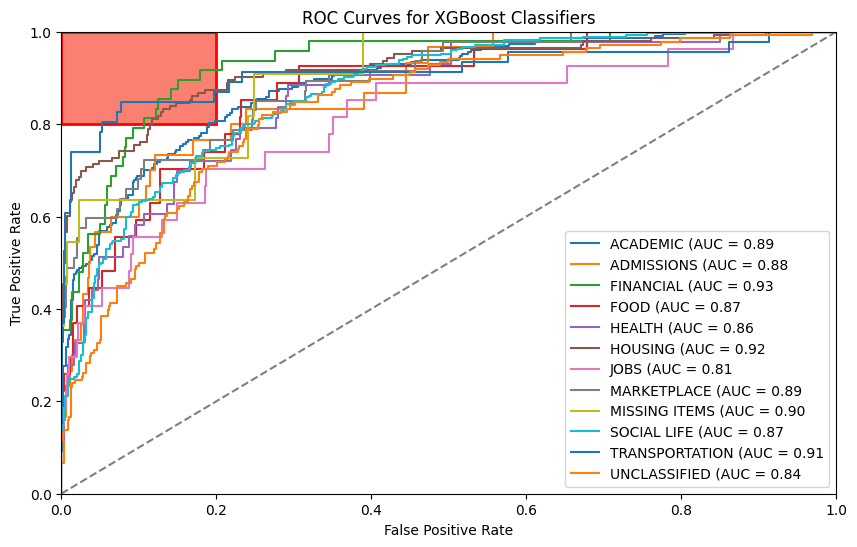

Optimal threshold for ACADEMIC: 0.2186926156282425
Optimal threshold for ADMISSIONS: 0.0274956077337265
Optimal threshold for FINANCIAL: 0.02216815948486328
Optimal threshold for FOOD: 0.0035415070597082376
Optimal threshold for HEALTH: 0.013073595240712166
Optimal threshold for HOUSING: 0.10048800706863403
Optimal threshold for JOBS: 0.0047523933462798595
Optimal threshold for MARKETPLACE: 0.0343356616795063
Optimal threshold for MISSING ITEMS: 0.001469282666221261
Optimal threshold for SOCIAL LIFE: 0.2851339876651764
Optimal threshold for TRANSPORTATION: 0.021003704518079758
Optimal threshold for UNCLASSIFIED: 0.0968288704752922


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.patches import Rectangle
import numpy as np



# Train XGBoost classifiers for each label (replace this with your actual classifiers)
classifiers = {x[0] : x[1] for x in zip(labels, best_models_weighted)}

# Plot ROC curves
# Plot ROC curves
plt.figure(figsize=(10, 6))

# Add the red square (overlay on the plot)

ax = plt.gca()
square = Rectangle((0, 0.8), 0.2, 0.2, fill=True, edgecolor='red', linewidth=2, facecolor='salmon')
ax.add_patch(square)
optimal_thresholds = {}
for label, clf in classifiers.items():
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(df.loc[y_test][label], y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Calculate the G-mean for each threshold
    g_means = np.sqrt(tpr * (1 - fpr))

    # Find the index of the threshold that maximizes the G-mean
    optimal_index = np.argmax(g_means)
    optimal_threshold = thresholds[optimal_index]
    optimal_thresholds[label] = optimal_threshold
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost Classifiers')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

for label, threshold in optimal_thresholds.items():
    print(f'Optimal threshold for {label}: {threshold}')

In [ ]:
for i, model in enumerate(best_models_weighted):
  model.save_model(f'./classifiers/{labels[i]}xgboostclassifier.model')

In [ ]:
test = XGBClassifier()
test.load_model(fname="./classifiers/ACADEMICxgboostclassifier.model")

In [ ]:
if test in best_models_weighted:
  print(True)

In [ ]:
y_pred_proba = test.predict_proba(X_test)[:, 1]

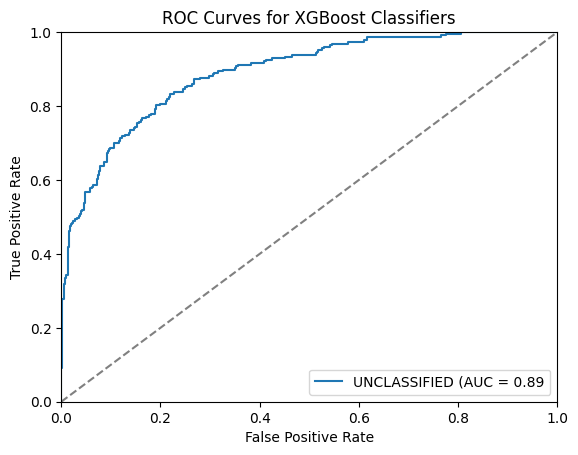

In [ ]:
fpr, tpr, _ = roc_curve(df.loc[y_test]['ACADEMIC'], y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost Classifiers')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [ ]:
""